In [75]:
import pandas as pd

train = pd.read_csv('train_dataset.csv')
test = pd.read_csv('test_dataset.csv')
train.head()

,id,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,num_user_for_reviews,language,country,content_rating,title_year,actor_2_facebook_likes,movie_facebook_likes,title_embedding,average_degree_centrality,imdb_score_binned
0,1,Roger Allers,186,73,28,847,Nathan Lane,2000,422783777,Adventure|Animation|Drama|Family|Musical,...,656,English,USA,G,1994,886,17000,[-4.1984697e-03 4.2941985e-03 -1.1961063e-03 ...,0.001576,4
1,2,George A. Romero,252,97,0,233,Shawn Roberts,654,20433940,Horror,...,662,English,Canada,R,2005,529,0,[-4.7586653e-03 2.6511205e-03 -3.7954253e-04 ...,0.000675,2
2,3,David Gordon Green,232,117,234,221,Tye Sheridan,12000,371897,Drama,...,118,English,USA,R,2013,1000,11000,[ 2.78131524e-03 -3.15494463e-03 -6.38332494e-...,0.003002,2
3,4,John Carpenter,297,109,0,145,Richard Masur,957,13782838,Horror|Mystery|Sci-Fi,...,911,English,USA,R,1982,163,23000,[-5.32674184e-03 3.60742491e-03 7.91795843e-...,0.001726,4
4,5,Peter Jackson,297,171,0,857,Orlando Bloom,16000,313837577,Action|Adventure|Drama|Fantasy,...,5060,English,New Zealand,PG-13,2001,5000,21000,[-4.2586620e-03 3.6257182e-03 -1.5326265e-03 ...,0.001876,4


In [76]:
# Remove any less than 10
train['country'].value_counts()

country
USA               2382
UK                 255
France              86
Germany             61
Canada              46
Australia           32
Spain               21
Japan               12
New Zealand         10
China                9
Hong Kong            9
Italy                8
South Korea          7
Ireland              6
Mexico               6
Denmark              6
Brazil               4
Thailand             3
South Africa         3
Argentina            3
Iran                 3
Netherlands          3
India                3
Norway               3
Taiwan               2
Czech Republic       2
Russia               2
Romania              2
Hungary              2
Colombia             1
Israel               1
West Germany         1
Official site        1
Afghanistan          1
Aruba                1
Chile                1
Finland              1
Iceland              1
Poland               1
Belgium              1
New Line             1
Indonesia            1
Name: count, dtype: int64

In [77]:
# Remove language column
train['language'].value_counts()

language
English       2872
French          32
Spanish         19
Mandarin         9
Japanese         9
German           9
Italian          5
Cantonese        5
Korean           4
Portuguese       4
Hindi            3
Norwegian        3
Dutch            3
Danish           3
Aboriginal       2
Thai             2
Indonesian       2
Dari             2
Persian          2
Kazakh           1
Maya             1
Aramaic          1
Filipino         1
Bosnian          1
Czech            1
Zulu             1
Vietnamese       1
Hungarian        1
Hebrew           1
Mongolian        1
Romanian         1
Arabic           1
Name: count, dtype: int64

In [78]:
import numpy as np

names_train = ['features_countvec/train_countvec_features_actor_1_name.npy', 'features_countvec/train_countvec_features_actor_2_name.npy', 
               'features_countvec/train_countvec_features_director_name.npy', 'features_doc2vec/train_doc2vec_features_genre.npy',
               'features_doc2vec/train_doc2vec_features_plot_keywords.npy', 'features_fasttext/train_fasttext_title_embeddings.npy']
names_test = ['features_countvec/test_countvec_features_actor_1_name.npy', 'features_countvec/test_countvec_features_actor_2_name.npy', 
               'features_countvec/test_countvec_features_director_name.npy', 'features_doc2vec/test_doc2vec_features_genre.npy',
               'features_doc2vec/test_doc2vec_features_plot_keywords.npy', 'features_fasttext/test_fasttext_title_embeddings.npy']

for name in names_train:
    print(name)
    print(len(np.load(name)[0]))

# The count vectors have too many columns and need to be trimmed

features_countvec/train_countvec_features_actor_1_name.npy
2063
features_countvec/train_countvec_features_actor_2_name.npy
2919
features_countvec/train_countvec_features_director_name.npy
2113
features_doc2vec/train_doc2vec_features_genre.npy
100
features_doc2vec/train_doc2vec_features_plot_keywords.npy
100
features_fasttext/train_fasttext_title_embeddings.npy
100


In [113]:
def create_columns(len, unique):
    columns = []
    for i in range(len):
        columns.append(str(i + unique))
    return columns

def drop_col(df):
    for col in df.columns:
        if (df[col].sum() < 5):
            df = df.drop(col, axis=1)
    return df

In [114]:
# Drop the number of columns due to too many dimensions, we will lose information but
# we can assume that actors and directors with lower frequency would be less popular and thus
# less well know, therefore they would have minimum effect on the success of the movie
# as viewers would not know if they are good or bad.
temp1 = np.load('features_countvec/train_countvec_features_actor_1_name.npy')
df_act_1 = pd.DataFrame(temp1, columns=create_columns(len(temp1[0]), 0))

temp2 = np.load('features_countvec/train_countvec_features_actor_2_name.npy')
df_act_2 = pd.DataFrame(temp2, columns=create_columns(len(temp2[0]), len(temp1[0])))

temp3 = np.load('features_countvec/train_countvec_features_director_name.npy')
df_dir = pd.DataFrame(temp3, columns=create_columns(len(temp3[0]), len(temp1[0]) + len(temp2[0])))

temp4 = np.load('features_doc2vec/train_doc2vec_features_genre.npy')
df_genre = pd.DataFrame(temp4, columns=create_columns(len(temp4[0]), len(temp1[0]) + len(temp2[0]) + 100))

temp5 = np.load('features_doc2vec/train_doc2vec_features_plot_keywords.npy')
df_keyword = pd.DataFrame(temp5, columns=create_columns(len(temp5[0]), len(temp1[0]) + len(temp2[0]) + 200))

temp6 = np.load('features_fasttext/train_fasttext_title_embeddings.npy')
df_title = pd.DataFrame(temp6, columns=create_columns(len(temp6[0]), len(temp1[0]) + len(temp2[0]) + 300))

df_act_1 = drop_col(df_act_1)
df_act_2 = drop_col(df_act_2)
df_dir = drop_col(df_dir)

In [115]:
print(len(df_act_1.columns))
print(len(df_act_2.columns))
print(len(df_dir.columns))

# Still too many columns

317
293
312


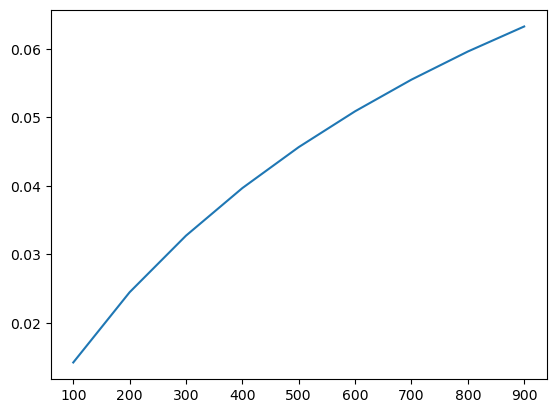

In [116]:
from sklearn.decomposition import PCA
#PCs = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 1000, 2000, 3000]
#PCs = [250, 500, 1000, 1500, 2000, 2500, 3000]
PCs = [100, 200, 300, 400, 500, 600, 700, 800, 900]
var = []
for n in PCs:

    pca = PCA(n_components=n)

    df_list = [df_act_1, df_act_2, df_dir, df_genre, df_keyword, df_title]
    train_pre_data = pd.concat(df_list, axis=1)

    columns = []
    for i in range(n):
        columns.append(str(i))

    principalComponents = pca.fit_transform(train_pre_data)

    var.append(np.var(principalComponents))
import matplotlib.pyplot as plt
cum_var = np.cumsum(var)

plt.plot(PCs, cum_var)
plt.show()

In [117]:
print(var)
# We will still with 500 principal components as that doesn't add too many columns to cause the curse of dimensionality

[0.01421345398265608, 0.010260925139465547, 0.008262450116923429, 0.006948700219095705, 0.005983226065512151, 0.0052329379840993905, 0.0046240938597153424, 0.0041052111604320644, 0.0036588684103213563]


In [92]:
# Implement PCA to cut down columns further
from sklearn.decomposition import PCA

pca = PCA(n_components=500)

df_list = [df_act_1, df_act_2, df_dir, df_genre, df_keyword, df_title]
train_pre_data = pd.concat(df_list, axis=1)

columns = []
for i in range(500):
    columns.append(str(i))

principalComponents = pca.fit_transform(train_pre_data)

df_pca = pd.DataFrame(data=principalComponents, columns=columns)

df_pca.head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,-0.042197,-0.018284,0.001335,-0.023595,-0.065694,-0.037430,0.032947,-0.005584,-0.017862,-0.045576,...,0.071762,0.161767,-0.218334,0.013352,-0.070636,-0.220307,-0.021062,-0.157031,0.051206,0.262476
1,-0.032508,0.021468,-0.034861,0.001943,-0.060856,-0.017966,-0.058533,0.006611,0.057193,-0.017408,...,-0.032766,-0.011778,-0.050710,-0.032527,-0.019698,0.071021,-0.019481,0.010459,-0.051184,-0.004439
2,-0.101498,0.046371,1.061335,0.137226,0.239568,-0.107802,-0.100195,-0.024319,0.058960,-0.036977,...,-0.084519,-0.052606,-0.035239,-0.062758,0.100011,0.029005,-0.045145,-0.045990,0.006886,-0.036695
3,0.914181,-0.453562,0.105443,-0.119085,-0.012729,-0.010846,-0.044996,-0.010632,0.041690,0.013393,...,0.158834,0.044094,-0.009112,-0.109719,-0.073819,-0.023171,-0.069534,0.091017,0.047332,0.037327
4,-0.044305,-0.065777,-0.052871,-0.070108,-0.174429,-0.108912,-0.165290,0.822122,-0.167236,0.687962,...,0.138410,0.142959,-0.026026,0.055603,0.131652,-0.051830,-0.014130,0.092676,-0.093744,0.135589


In [93]:
#test_pre_data = pd.DataFrame()

#df_list = [df_act_1, df_act_2, df_dir, df_genre, df_keyword, df_title]
#train_pre_data = pd.concat(df_list, axis=1)

# Drop old columns and unnecessary columns
titles = ['actor_1_name', 'actor_2_name', 'director_name', 'genres', 'plot_keywords', 'language', 'country',
            'title_embedding', 'movie_title', 'actor_3_name', 'actor_3_facebook_likes']
train_new = pd.concat([train.drop(columns=titles), df_pca], axis=1)

print(len(train_new.columns))
train_new.head()


216


,id,num_critic_for_reviews,duration,director_facebook_likes,actor_1_facebook_likes,gross,num_voted_users,cast_total_facebook_likes,facenumber_in_poster,num_user_for_reviews,...,190,191,192,193,194,195,196,197,198,199
0,1,186,73,28,2000,422783777,644348,6458,0,656,...,0.071762,0.161767,-0.218334,0.013352,-0.070636,-0.220307,-0.021062,-0.157031,0.051206,0.262476
1,2,252,97,0,654,20433940,78883,1876,8,662,...,-0.032766,-0.011778,-0.050710,-0.032527,-0.019698,0.071021,-0.019481,0.010459,-0.051184,-0.004439
2,3,232,117,234,12000,371897,36494,13607,2,118,...,-0.084519,-0.052606,-0.035239,-0.062758,0.100011,0.029005,-0.045145,-0.045990,0.006886,-0.036695
3,4,297,109,0,957,13782838,258078,1757,0,911,...,0.158834,0.044094,-0.009112,-0.109719,-0.073819,-0.023171,-0.069534,0.091017,0.047332,0.037327
4,5,297,171,0,16000,313837577,1238746,22342,2,5060,...,0.138410,0.142959,-0.026026,0.055603,0.131652,-0.051830,-0.014130,0.092676,-0.093744,0.135589


In [94]:
# Remove less than 50
train['content_rating'].value_counts()

content_rating
R            1362
PG-13        1039
PG            458
G              68
Not Rated      27
Unrated        19
Approved       14
X               9
NC-17           3
M               2
Passed          2
GP              1
Name: count, dtype: int64

In [95]:
# Remove low frequency ratings
count = train_new['content_rating'].value_counts()
train_new = train_new[~train_new['content_rating'].isin(count[count < 50].index)]  

# Combine PG ratings
train_new.loc[train_new.content_rating == 'PG-13', 'content_rating'] = 'PG'

from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder()
encoded = enc.fit_transform(train_new[['content_rating']])

df_temp = pd.DataFrame(encoded.toarray(), columns=['G', 'PG', 'R'])

train_new = pd.concat([train_new.drop(columns='content_rating'), df_temp], axis=1)

train_new.head()


,id,num_critic_for_reviews,duration,director_facebook_likes,actor_1_facebook_likes,gross,num_voted_users,cast_total_facebook_likes,facenumber_in_poster,num_user_for_reviews,...,193,194,195,196,197,198,199,G,PG,R
0,1.0,186.0,73.0,28.0,2000.0,422783777.0,644348.0,6458.0,0.0,656.0,...,0.013352,-0.070636,-0.220307,-0.021062,-0.157031,0.051206,0.262476,1.0,0.0,0.0
1,2.0,252.0,97.0,0.0,654.0,20433940.0,78883.0,1876.0,8.0,662.0,...,-0.032527,-0.019698,0.071021,-0.019481,0.010459,-0.051184,-0.004439,0.0,0.0,1.0
2,3.0,232.0,117.0,234.0,12000.0,371897.0,36494.0,13607.0,2.0,118.0,...,-0.062758,0.100011,0.029005,-0.045145,-0.045990,0.006886,-0.036695,0.0,0.0,1.0
3,4.0,297.0,109.0,0.0,957.0,13782838.0,258078.0,1757.0,0.0,911.0,...,-0.109719,-0.073819,-0.023171,-0.069534,0.091017,0.047332,0.037327,0.0,0.0,1.0
4,5.0,297.0,171.0,0.0,16000.0,313837577.0,1238746.0,22342.0,2.0,5060.0,...,0.055603,0.131652,-0.051830,-0.014130,0.092676,-0.093744,0.135589,0.0,1.0,0.0


In [96]:
# Added NaN values were added by one hot encoding, they should be removed
train_final = train_new.dropna()
y = train_final['imdb_score_binned']
X = train_final.drop(columns=['imdb_score_binned'])
len(X)

2855

In [ ]:
# Apply post processing, ie normalisation, standardisation
# Remove outliers

In [97]:
from sklearn import svm

svm_model = svm.SVC()
svm_model.fit(X, y)


SVC()